In [140]:
import json
import requests
import time
from datetime import datetime

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.dates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

import seaborn as sns
sns.set(style="darkgrid")

Jordan Heath
1/05/19

Work for WR Stakeholder presentation with Gerry

# API Get


The Cityworks API token, along with the API call for the specific action need to be joined. The join is then tested with a random WO.

In [2]:
  # Cityworks user token
token = (r'eyJFbXBsb3llZVNpZCI6MjYxOTEsIklzc3VlZFRpbWUiOjE1Mzk3OTIwNzYxNjYsIkxvZ2luTmF'
    r'tZSI6ImpoZWF0aCIsIlNpZ25hdHVyZSI6IitiOFBGRFkyY0xaYkFDMzFYVm1XeDdGZ0txWWZBOU52YytiSz'
    r'c4VnZFZUk9IiwiVG9rZW4iOiJDYWtOMFJTemNWZC9RNkhkRnI2NFRxRXBlM3JWSnVqS2FBZitrYW1IL1owPSJ9')

  # First part of the API call for WO
wo_urlp1 = (r'http://cityworks.portlandmaine.gov/Cityworks/Services/AMS/WorkOrder/'
        r'ById?data={"WorkOrderId":"')

  # Second part of the API call for WO
wo_urlp2 = (r'"}&token=')

  # First part of the API call for WO Tasks
task_urlp1 = (r'http://cityworks.portlandmaine.gov/Cityworks/Services/AMS/Tasks/'
        r'ByWorkOrder?data={"WorkOrderIds":["')

  # Second part of the API call for WO Tasks
task_urlp2 = (r'"]}&token=')

  # testing if it works
print("53316".join((task_urlp1,task_urlp2))+token)  # token test

http://cityworks.portlandmaine.gov/Cityworks/Services/AMS/Tasks/ByWorkOrder?data={"WorkOrderIds":["53316"]}&token=eyJFbXBsb3llZVNpZCI6MjYxOTEsIklzc3VlZFRpbWUiOjE1Mzk3OTIwNzYxNjYsIkxvZ2luTmFtZSI6ImpoZWF0aCIsIlNpZ25hdHVyZSI6IitiOFBGRFkyY0xaYkFDMzFYVm1XeDdGZ0txWWZBOU52YytiSzc4VnZFZUk9IiwiVG9rZW4iOiJDYWtOMFJTemNWZC9RNkhkRnI2NFRxRXBlM3JWSnVqS2FBZitrYW1IL1owPSJ9


______

Next, a spreadsheet of exported WO#s is pulled into a dataframe. That dataframe is then given extra columns.

In [3]:
work_book = r'C:\Users\Kerling\Documents\JupyterNotebooks\Cityworks\PS_WO_2019.xlsx'
#work_book = (r'C:\\Users\\Kerling\\Documents\\PycharmProjects\\ScadaData\\'
#    r'cityworks\\PS_WO.xlsx') #2018_small

time_format = '%Y-%m-%d'

address = 'Address'
date = 'Date'
cost = 'Cost'
tasks = 'Tasks'
work = 'Work'

  # dataframe for base WO data
df = pd.read_excel(open(work_book,'rb'), usecols = "B", sheet_name=0)  # Pull data from excel
dataframe = df.rename(columns={"WorkOrderId":work})  # rename column to something shorter

  # adding dataframe columns
dataframe[address] = None
dataframe[date] = None
dataframe[cost] = None
dataframe[tasks] = None

______

The API calls then get() data from the Cityworks API, using the WO#s inserted into the dataframe. 
Relevant data is then inserted into the same dataframe (address, data, cost, tasks).

In [5]:
start = time.time()
dataframe[work] = dataframe[work].astype(str)
for index, row in dataframe.iterrows():# iterate through dataframe row by row
    #Address/date/cost Section grabbed from WO url
    wo_url = row[work].join((wo_urlp1,wo_urlp2))
    wo_url = wo_url + token
    try:
        parsedWO = json.loads(requests.get(wo_url).text)
    except:
        pass
    _address = parsedWO['Value']['WOAddress']
    _date = parsedWO['Value']['DateWOClosed']
    
    try: # open work orders cause issues, no closed date. Data shows only one atm
        _date = pd.Timestamp(_date.split("T")[0])
    except:  # not good practice to do a blanked excpet, but small line of code so did it anyway
        pass
    
    _cost = parsedWO['Value']['WOCost'] #full cost

    #task section grabbed from task url
    task_url = row[work].join((task_urlp1,task_urlp2))   
    task_url = task_url + token
    parsedTasks = json.loads(requests.get(task_url).text)
    _tasks = [t['Description'] for t in parsedTasks['Value']]
    
    #main dataframe
    dataframe.at[index,cost] = _cost
    dataframe.at[index,address] = _address
    dataframe.at[index,date] = _date
    dataframe.at[index,tasks] = _tasks
    
    #time.sleep(1) # IT issues with API

In [11]:
print("Total cost of WOs:",round(dataframe['Cost'].sum(),2))
      
print("Total WOs:",dataframe['Work'].count())

Total cost of WOs: 25740.25
Total WOs: 744


______

The below iterates through the main dataframe, and with eachrow it renames the address field to the correct spelling
(this is due to several different address spelings for each address).
Script will then add that address' row to a dataframe named after that address.

The data that comes from the API is mainly populated in the field by the operators, and contains some inconsistencies. the sorter(alias, string) function attempts to renamed all addresses to a standard.

In [34]:
# Pumpstation lists
castine = pd.DataFrame(columns = dataframe.columns)
franklin = pd.DataFrame(columns = dataframe.columns)
riverside = pd.DataFrame(columns = dataframe.columns)
pennel = pd.DataFrame(columns = dataframe.columns)
linden = pd.DataFrame(columns = dataframe.columns)
partridge = pd.DataFrame(columns = dataframe.columns)
hope = pd.DataFrame(columns = dataframe.columns)
riverton = pd.DataFrame(columns = dataframe.columns)
curtis = pd.DataFrame(columns = dataframe.columns)
eastend = pd.DataFrame(columns = dataframe.columns)

  # list for handling different PS spellings
alias_list = [['castine','Castine PS'],# castine],
              ['franklin','Franklin PS'], #franklin],
              ['riverside','Riverside PS'], #riverside],
              ['pennel','Pennel PS'], #pennel],
              ['linden','Linden PS'], #linden],
              ['riverton','Riverton PS'], #riverton],
              ['hope','Hope PS'], #hope],
              ['curtis','Curtis PS'], #curtis],
              ['partridge','Partridge PS'], #partridge],
              ['east','East End PS']] #eastend]]


def sorter(alias,string):
    """
    alias = alias_list from above
    string = address from cityworks API
    """
    for y in alias:
        
        try:
            if y[0] in string.lower():
    
                return y[1]
        except:  # some WOs dont have an address
            pass
        

# I tried a much more compact function, but it did not work and debugging got
# me nowhere. TODO: look at more closely later
for index, row in dataframe.iterrows(): #iterates through dataframe

    dataframe.at[index,address] = sorter(alias_list,row[address]) # address change
    
    for alias in alias_list:
        
        if row[address] == alias[1]:
            #print(alias[1])
            for i in row[tasks]:

                # creates a temporary dataframe of one row to be inserted into the 
                # pump station's main dataframe
                _temp = pd.DataFrame([[row[work],
                      row[address],
                      row[date],
                      row[cost]/len(row[tasks]), # divides total cost by # of tasks
                      i]],columns=dataframe.columns)

                #print(row[address])
                try:  # filters the above _temp it's respective pumpstation
                      # there are faster ways, but when dealing with 800 WOs it isnt a big deal
                    if  row[address] == 'Castine PS':
                        castine = castine.append(_temp,ignore_index=True)
                    elif row[address] == 'Franklin PS':
                        franklin = franklin.append(_temp,ignore_index = True)
                    elif row[address] == 'Riverside PS':
                        riverside = riverside.append(_temp,ignore_index = True)
                    elif row[address] == 'Pennel PS':
                        pennel = pennel.append(_temp,ignore_index = True)
                    elif row[address] == 'Linden PS':
                        linden = linden.append(_temp,ignore_index = True)
                    elif row[address] == 'Riverton PS':
                        riverton = riverton.append(_temp,ignore_index = True)
                    elif row[address] == 'Hope PS':
                        hope = hope.append(_temp,ignore_index = True)
                    elif row[address] == 'Curtis PS':
                        curtis = curtis.append(_temp,ignore_index = True)
                    elif row[address] == 'Partridge PS':
                        partridge = partridge.append(_temp,ignore_index = True)
                    elif row[address] == 'East End PS':
                        eastend = eastend.append(_temp,ignore_index = True)
                except:
                    print('failed at', row)

______

_____

# Plotting the Basics

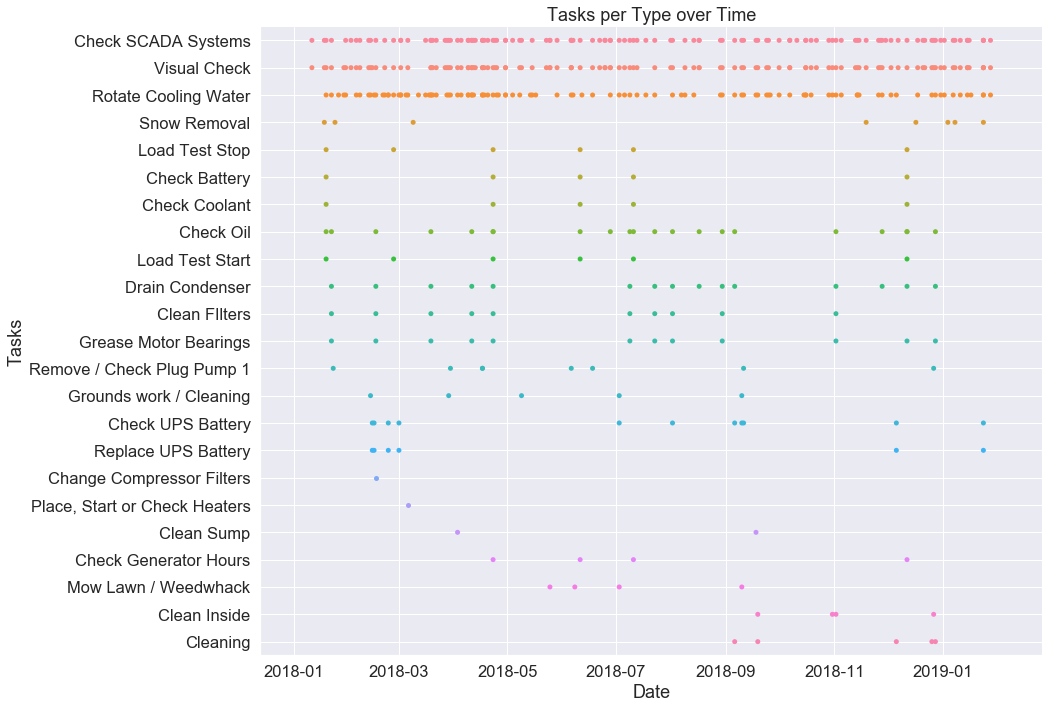

In [178]:
# Task Frequency
sns.catplot(x='Date', y='Tasks', jitter=False, data=franklin, height = 10, aspect = 1.5)
ax = plt.gca()
ax.set_title("Tasks per Type over Time")
sns.set(font_scale=1.5)
ax.grid(True)
plt.show()

In the above chart the tasks were plotted by type over time for the Franklin pump station, giving an understanding of the frequency of tasks.

________

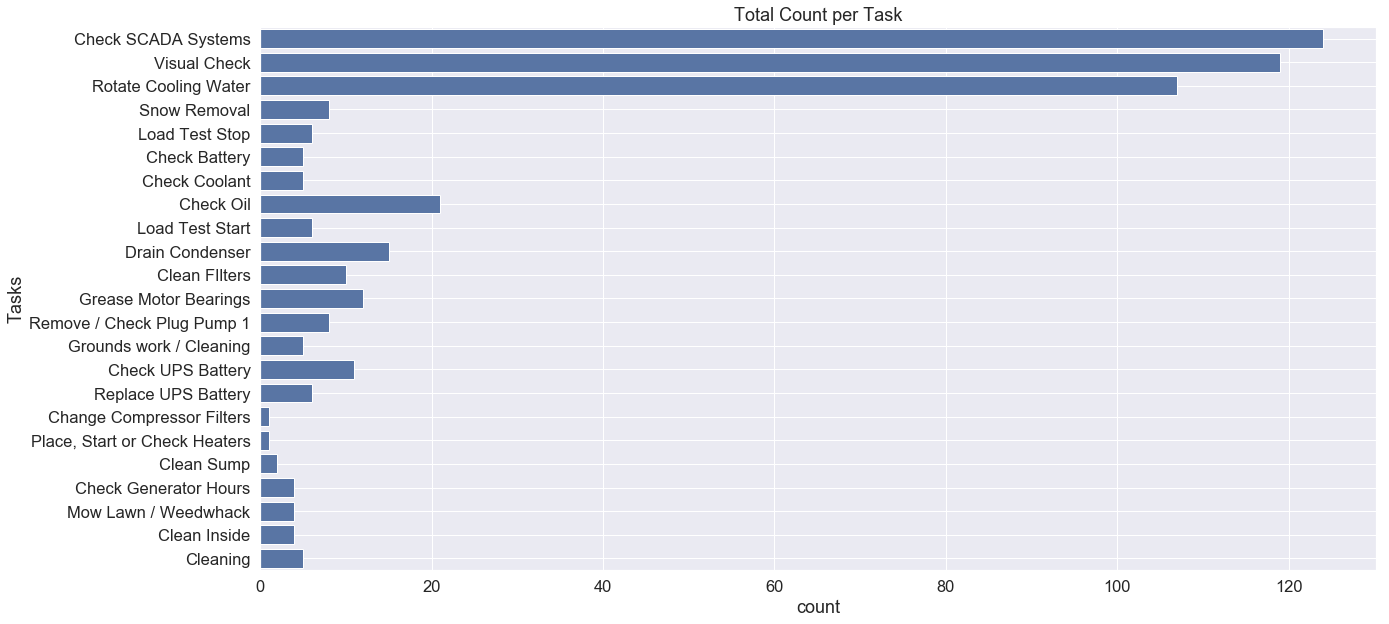

In [167]:
# Task count
sns.countplot(y='Tasks', data=temp_df, color='b')
sns.set(font_scale=1.5)
ax = plt.gca()
ax.set_title('Total Count per Task')
ax.grid(True)
#ax.set_xticklabels(np.linspace(1,120,120))

plt.show()

Then for each pump station the total count per tasks can be calculated and displayed.

_______

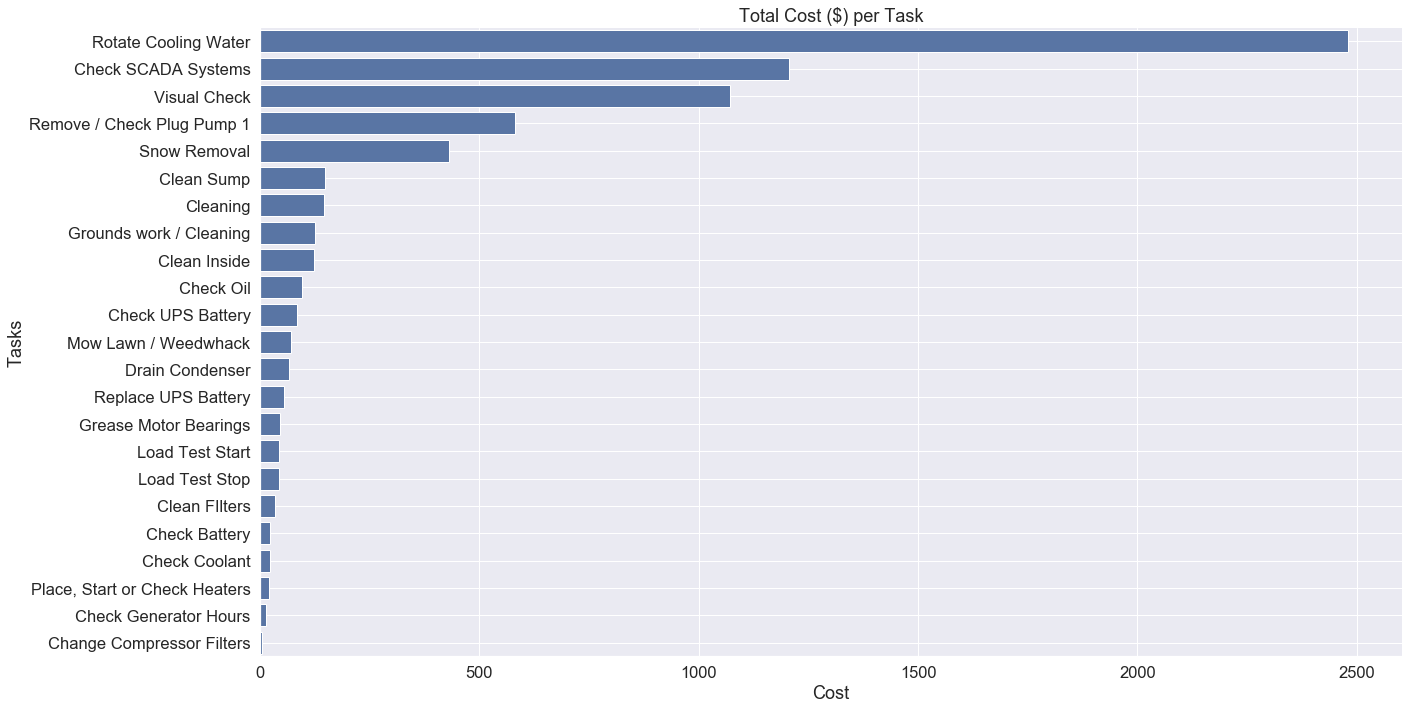

In [169]:
df3 = franklin[['Cost','Tasks']].groupby('Tasks').sum().reset_index()
df3 = df3.sort_values('Cost', ascending = False)
sns.catplot(x='Cost',y = 'Tasks', kind= 'bar', data=df3, color = 'b', height = 10, aspect = 2)
sns.set(font_scale=1.5)
ax = plt.gca()
ax.set_title('Total Cost ($) per Task')
ax.grid(True)
#ax.set_xticklabels(np.linspace(1,120,120))

plt.show()

The total cost per Task can also be plotted to examine the Tasks which costs the most. Right now Rotate Cooling Water is bar far the greatest single cost for the pump station, this is due to having to manually rotate the cooling water for the pump cooling system. fiscal year 2020 will see this system upgraded to an automated version. The cost of upgraded can be compared to this data, and a payoff period can be calculated.

______

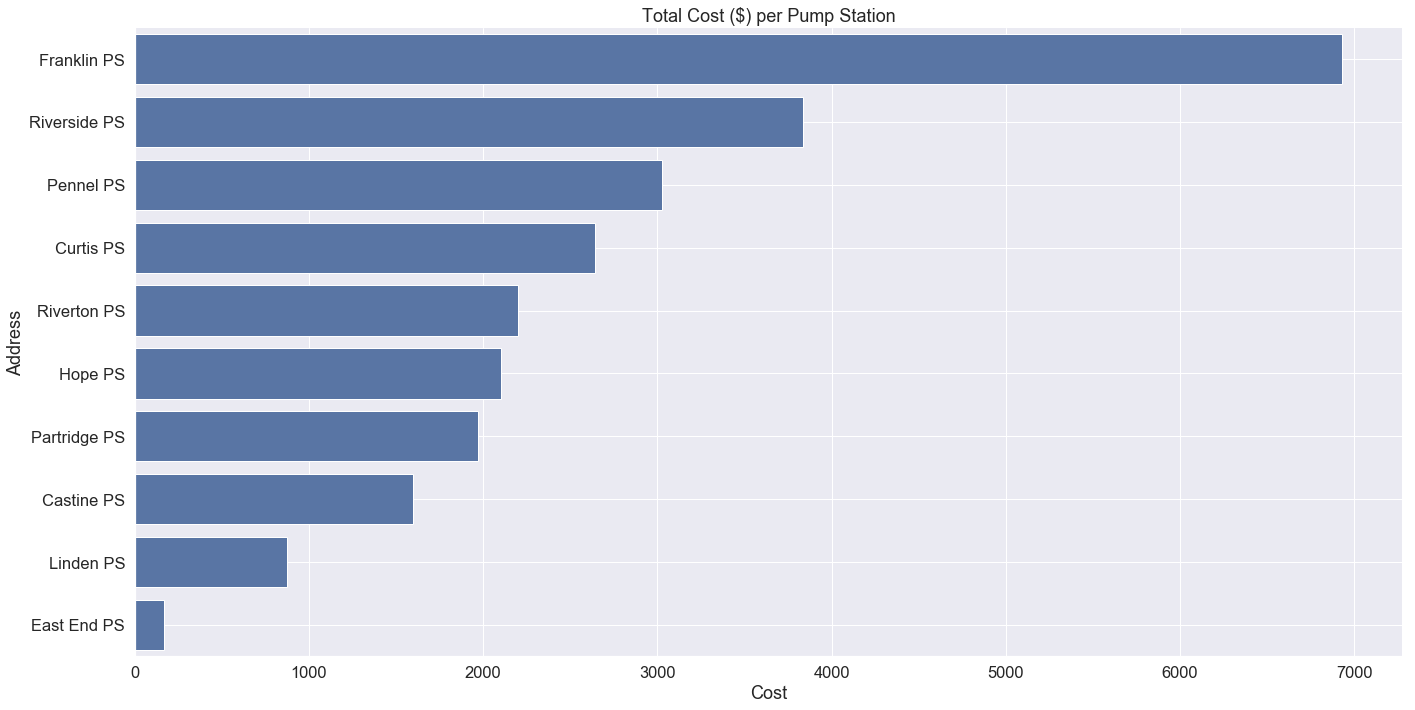

In [172]:
total_cost = dataframe[['Address','Cost']].groupby('Address').sum().reset_index()
total_cost = total_cost.sort_values('Cost', ascending=False)
sns.catplot(x='Cost',y = 'Address', kind= 'bar', data=total_cost, color = 'b', height = 10, aspect = 2)
sns.set(font_scale=1.5)
ax = plt.gca()
ax.set_title('Total Cost ($) per Pump Station')
ax.grid(True)

plt.show()

Much like the previous graph, the total cost per pump station can be plotted and examined. Franklin, being the largest pump station costs the most, while the East End pump station is only active in the summer, as its flow is 100% East End Beach facilities flow.

_______

_____

# Frequency and Task Forecasting

To gather frequency data two dataframes need to ultimately be created. One containing, for each task, the days since it was last performed. Other that will the be populated with a frequency calculated from the mean of the 'days since' value. 

A more robust model could perform a high lever statistical analysis, taking in to account weather, season, time of day performed, etc - but this is just to create a simple model that can be followed week by week, by anybody.

In [179]:
linear = temp_df.sort_values('Date')  # need a dataframe where the values are chronologically sorted
uniques = set(linear['Tasks'])  # need a container of unique task names

# creating a new dataframe with a new column, called Gap, which stores the days since it was last performed
days_since_df = franklin
days_since_df['Gap'] = np.nan  # set new column to Nan

# creating a new dataframe with a new column for frequency
tmp_df = franklin[['Tasks']].groupby('Tasks').size().reset_index()
freq_df = tmp_df.rename(columns={0:'Count'})  # rename column
freq_df['Freq'] = np.nan  # set new column to Nan

def tasks_mean_time(task):
    """
    This function takes in a unique task name, then iterates through the linear dataframe
    and searches for rows containing the inputed task name. When it finds that task it will
    compare the date in that row, to the date of the row where the task name was last seen. Since
    the linear dataframe is chronologically sorted the function can then subtract the two dates to find
    the "days since" value for the Gap column in days_since_df.
    
    Then, once the linear dataframe has been completely iterated through the function will determine the mean of the days
    stored in the days list. That mean value is then added to the freq_df "Freq" column for the respective task.
    
    task: current task
    """
    _temp = None  # temp storage for each date
    days = []  # container for days_since value
    days_and_date = []  # container for  days_since and date used
    #print(task)
    for index, row in linear.iterrows():  # iterates through dataframe
        if row['Tasks'] == task:  # finds rows with containing function's current task
            if _temp is not None:
                
                days_since = ((row['Date']-_temp)/np.timedelta64(1,'D'))  # subtracting two dates then converting to days
                days.append(days_since)
                days_and_date.append((days_since, row['Date']))

                for _index, _row in days_since_df.iterrows():
                    
                    if row['Date']  == _row['Date'] :
                        
                        if row['Tasks'] == _row['Tasks']:
                    
                            days_since_df.at[_index,'Gap'] = days_since
      
            _temp= row['Date']
            

    if len(days) > 1:  # if list isnt empty
        days_mean = np.mean(days)  # find the mean days

        for _index, _row in freq_df.iterrows():  # iterates through dataframe
            if _row['Tasks'] == task:
                freq_df.at[_index,'Freq'] = round(days_mean)  # adding that mean to the freq_df dataframe

for task in uniques:
    tasks_mean_time(task)

# uncomment the below to manually inspect the frequency value. It is working now, but took some doing.
#days_since_df.loc[days_since_df['Tasks']=='Rotate Cooling Water']

After calculating the days since and mean values, the freq_df can be displayed to examine the values.

In [180]:
freq_df

,Tasks,Count,Freq
0,Change Compressor Filters,1,NaN
1,Check Battery,5,82.0
2,Check Coolant,5,82.0
3,Check Generator Hours,4,78.0
4,Check Oil,21,17.0
5,Check SCADA Systems,124,3.0
6,Check UPS Battery,11,34.0
7,Clean FIlters,10,32.0
8,Clean Inside,4,33.0
9,Clean Sump,2,NaN


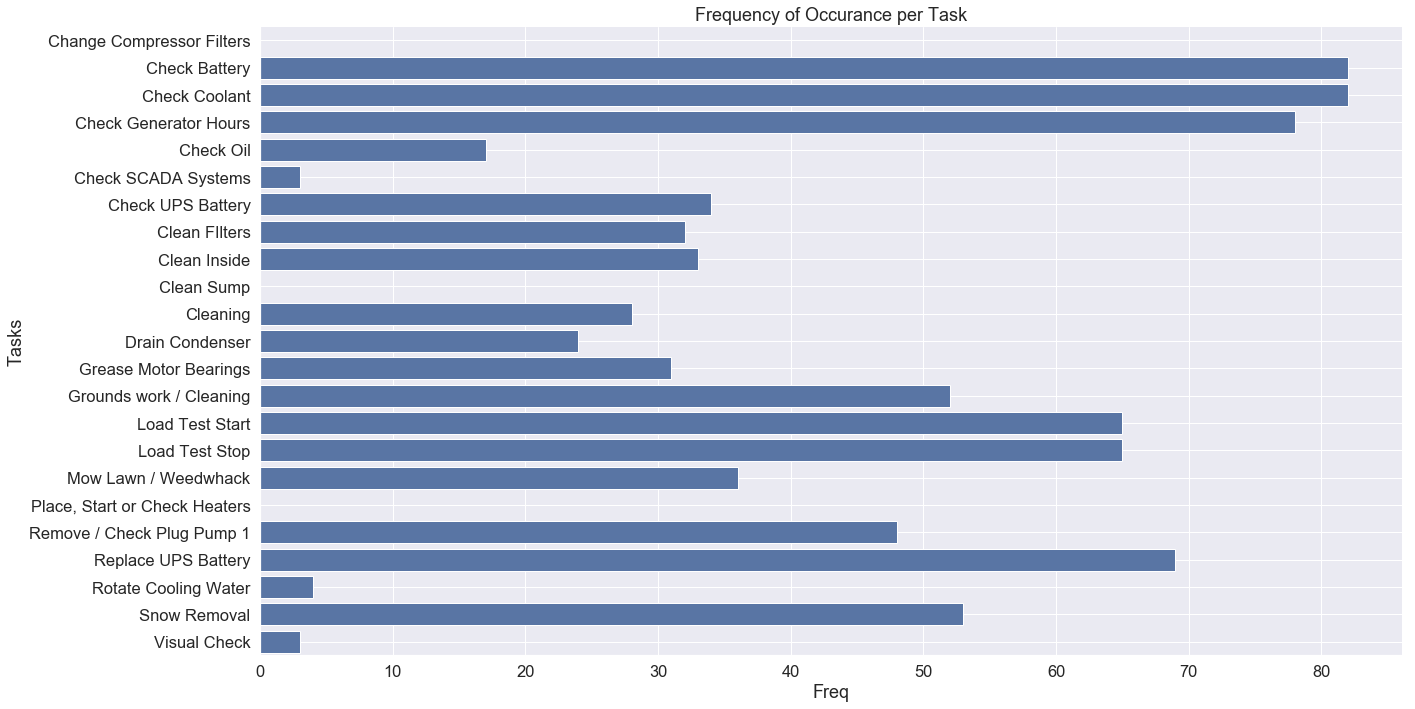

In [181]:
sns.catplot(x="Freq",y = 'Tasks', kind= 'bar', data=freq_df, color = 'b', height = 10, aspect = 2)
sns.set(font_scale=1.5)
ax = plt.gca()
ax.set_title("Frequency of Occurance per Task")
ax.grid(True)
#ax.set_xticklabels(np.linspace(1,120,120))

plt.show()

The frequencies can then be plotted for a more viual understanding. From this point the analysis then turns into a more opinion based one. It takes an understanding of how the operations and maintenance of the pump stations is run, to determine if the frequency value should be used. Though, some things stand out right away: Snow Removal is probably not something to be done every 53 days. Visual Check, though, should definitely be done every 3 days.